# DAG visualization


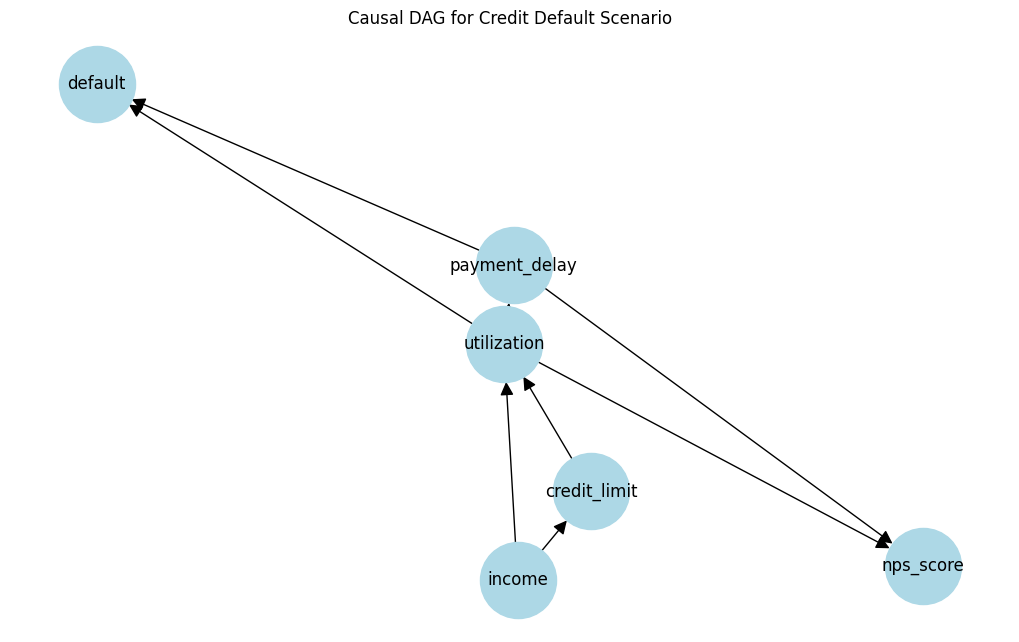

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = ["income", "credit_limit", "utilization", "payment_delay", "nps_score", "default"]
edges = [
    ("income", "credit_limit"),
    ("credit_limit", "utilization"),
    ("income", "utilization"),
    ("utilization", "payment_delay"),
    ("payment_delay", "nps_score"),
    ("utilization", "nps_score"),
    ("utilization", "default"),
    ("payment_delay", "default"),
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)  

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20, font_size=12)
plt.title("Causal DAG for Credit Default Scenario")
plt.show()


# Causal effect estimation


In [15]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('Simulated_Causal_Credit_Dataset.csv')
data = df.copy()

G = nx.DiGraph()
G.add_edges_from([
    ("income", "credit_limit"),
    ("credit_limit", "utilization"),
    ("income", "utilization"),
    ("utilization", "payment_delay"),
    ("payment_delay", "nps_score"),
    ("utilization", "nps_score"),
    ("utilization", "default"),
    ("payment_delay", "default"),
])

causal_graph_dot = nx.nx_pydot.to_pydot(G).to_string()

model = CausalModel(
    data=data,
    treatment="credit_limit",
    outcome="default",
    graph=G 
)


identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)
print(f"Causal Effect of credit_limit on default: {estimate.value}")

refutation = model.refute_estimate(identified_estimand, estimate,
                                   method_name="placebo_treatment_refuter")
print(refutation)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
──────────────(E[default|income])
d[creditₗᵢₘᵢₜ]                   
Estimand assumption 1, Unconfoundedness: If U→{credit_limit} and U→default then P(default|credit_limit,income,U) = P(default|credit_limit,income)

## Realized estimand
b: default~credit_limit+income
Target units: ate

## Estimate
Mean value: 1.961162856012333e-05

Causal Effect of credit_limit on default: 1.961162856012333e-05
Refute: Use a Placebo Treatment
Estimated effect:1.961162856012333e-05
New effect:0.0
p value:1.0



 # Refutation using placebo treatment or random common causes

In [16]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


refutation_placebo = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="placebo_treatment_refuter"
)
print(refutation_placebo)

refutation_random = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(refutation_random)


Refute: Use a Placebo Treatment
Estimated effect:1.961162856012333e-05
New effect:0.0
p value:1.0

Refute: Add a random common cause
Estimated effect:1.961162856012333e-05
New effect:1.9687920979613027e-05
p value:0.8999999999999999



# Bootstrap Refuter

In [37]:
from dowhy import CausalModel

model = CausalModel(
    data=data,
    treatment="X",
    outcome="Y",
    graph=causal_graph
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Estimated effect:", estimate.value)

refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="bootstrap_refuter",
    method_params={"num_simulations": 100}
)

print(refute_results)


Estimated effect: -0.017540978363727297
Refute: Bootstrap Sample Dataset
Estimated effect:-0.017540978363727297
New effect:-0.0076381595771212495
p value:0.8799999999999999



In [41]:
# Placebo Treatment Refuter
placebo_refute_results = model.refute_estimate(
    estimand=identified_estimand,
    estimate=estimate,
    method_name="placebo_treatment_refuter",
    method_params={"placebo_type": "permute"}
)
print(placebo_refute_results)


random_common_cause_results = model.refute_estimate(
    estimand=identified_estimand,
    estimate=estimate,
    method_name="random_common_cause"
)
print(random_common_cause_results)


Refute: Use a Placebo Treatment
Estimated effect:-0.017540978363727297
New effect:0.006776504361305785
p value:0.8600000000000001

Refute: Add a random common cause
Estimated effect:-0.017540978363727297
New effect:-0.01766001766578462
p value:0.96



In [42]:
data_subset_refuter_results = model.refute_estimate(
    estimand=identified_estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    method_params={"subset_fraction": 0.8, "num_simulations": 50}
)
print(data_subset_refuter_results)


Refute: Use a subset of data
Estimated effect:-0.017540978363727297
New effect:-0.02292124930650577
p value:0.96



# Senstivity Analysis

In [44]:
sensitivity_results = model.refute_estimate(
    estimand=identified_estimand,
    estimate=estimate,
    method_name="add_unobserved_common_cause",
    method_params={"confounder_effect_strength": 0.1}  
)

print(sensitivity_results)



Refute: Add an Unobserved Common Cause
Estimated effect:-0.017540978363727297
New effect:-0.10153027226988603



/Users/vasukhare/Desktop/Bayesian Decision Network for Policy Simulation/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Visualization

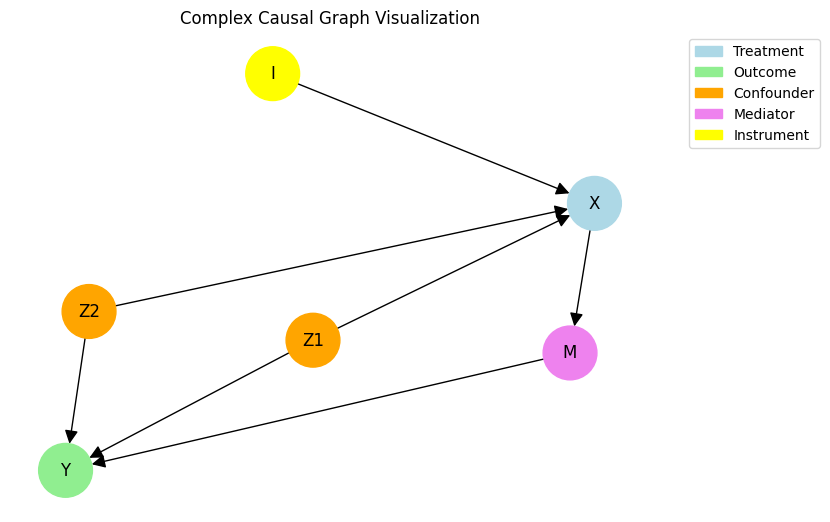

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

nodes = {
    "X": "Treatment",
    "Y": "Outcome",
    "Z1": "Confounder",
    "Z2": "Confounder",
    "M": "Mediator",
    "I": "Instrument"
}

color_map = {
    "Treatment": "lightblue",
    "Outcome": "lightgreen",
    "Confounder": "orange",
    "Mediator": "violet",
    "Instrument": "yellow"
}

for node, role in nodes.items():
    G.add_node(node, role=role)

edges = [
    ("Z1", "X"),
    ("Z1", "Y"),
    ("Z2", "X"),
    ("Z2", "Y"),
    ("X", "M"),
    ("M", "Y"),
    ("I", "X"),
]

G.add_edges_from(edges)


node_colors = [color_map[G.nodes[n]["role"]] for n in G.nodes]


pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=12, arrowsize=20)

import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=color, label=role) for role, color in color_map.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Complex Causal Graph Visualization")
plt.show()


# Bayesian Network

In [49]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

model = DiscreteBayesianNetwork([
    ('Z', 'X'),  # Z causes X
    ('X', 'Y'),  # X causes Y
])

cpd_Z = TabularCPD(variable='Z', variable_card=2, values=[[0.6], [0.4]])

cpd_X_given_Z = TabularCPD(
    variable='X',
    variable_card=2,
    values=[[0.7, 0.2],
            [0.3, 0.8]],
    evidence=['Z'],
    evidence_card=[2]
)

cpd_Y_given_X = TabularCPD(
    variable='Y',
    variable_card=2,
    values=[[0.9, 0.4],
            [0.1, 0.6]],
    evidence=['X'],
    evidence_card=[2]
)

model.add_cpds(cpd_Z, cpd_X_given_Z, cpd_Y_given_X)

assert model.check_model(), "Model is invalid!"

inference = VariableElimination(model)

query_result = inference.query(variables=['Y'], evidence={'X': 1})
print("P(Y | X=1):")
print(query_result)

prior_Y = inference.query(variables=['Y'])
print("\nP(Y) prior distribution:")
print(prior_Y)


P(Y | X=1):
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.4000 |
+------+----------+
| Y(1) |   0.6000 |
+------+----------+

P(Y) prior distribution:
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6500 |
+------+----------+
| Y(1) |   0.3500 |
+------+----------+


In [53]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
import numpy as np

# Assuming `model` is your DiscreteBayesianNetwork already fitted with CPDs

inference = VariableElimination(model)

correct = 0
total = len(data)

for index, row in data.iterrows():
    evidence = {'X': row['X']}  # You can add other observed vars if any
    query_result = inference.query(['Y'], evidence=evidence)
    
    # Get the most probable state of Y predicted by the model
    predicted_y = np.argmax(query_result.values)
    
    # Compare with true Y
    if predicted_y == row['Y']:
        correct += 1

accuracy = correct / total
print(f"Predictive accuracy: {accuracy:.2%}")


Predictive accuracy: 50.00%
